Utils

In [5]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import scipy.stats as stats

import scipy
import pywt
import mne
from mne.decoding import CSP
import math

import pickle

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold, cross_val_score, LeaveOneGroupOut

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder


from mne.time_frequency import AverageTFRArray

import sys
from tqdm import tqdm


sys.path.append('../utils')
from ERP_utils import *
from update_sub_lists import *
from wavelet_utils import *
from stats_utils import *
import glob
import os

from mne.time_frequency import AverageTFRArray
import seaborn as sns
import warnings

from mne.decoding import UnsupervisedSpatialFilter
from sklearn.decomposition import PCA, FastICA

#warnings and logs
warnings.simplefilter(action='ignore', category=FutureWarning)
mne.set_log_level('CRITICAL') #'INFO' for more detail, 'CRITICAL' for smaller output


In [6]:
def get_xy_filtered(file, label, filter = True, drop_bads = True, **kwargs):
    """
    gets the X data and y labels from an epochs object.
    sub: string e.g. '01'

    ---
    returns:
    X: epochs data of shape n_trials x n_channels (64 eeg channels) x n_times
    y: labels of size n_trials. Typically 1 for pre and 2 for post.
    """

    eps = mne.read_epochs(file)

    #drop bad epochs
    if drop_bads:
        drop_bads_kwargs = {key: value for key, value in kwargs.items() if key in ['reject', 'flat']}
        eps.drop_bad(**drop_bads_kwargs)  # Only pass relevant kwargs

        

    if filter:
        eps_filt = eps.copy()
        filter_kwargs = {key: value for key, value in kwargs.items() if key in ['l_freq', 'h_freq', 'method', 'iir_params']}
        eps_filt.filter(**filter_kwargs) 
        x = eps_filt.get_data()[:,:64, :]
    else:
        x = eps.get_data()[:, :64, :] #get eeg channels only
    
    #label array
    y = np.full_like(x[:,0,0], label)

    return x, y
   

   
def ep_PCA(epochs_data, n_components):
    """ 
    Performs PCA on epochs
    epochs_data: n_trials x n_channels x n_times
    ---
    Returns
    X_reconstructed: the PCA transformation that is projected back to channel space (64 channels)
    
    """
    pca = UnsupervisedSpatialFilter(PCA(n_components), average=False)
    X_pca = pca.fit_transform(epochs_data)


    #reconstruct PCA into EEG channel space
    #X_reconstructed = np.empty_like(X)  # Placeholder for reconstructed data
    X_reconstructed = pca.inverse_transform(X_pca)
    return X_reconstructed, X_pca

Parameters

In [7]:

#epochs parameters
iir_params = dict(order=8, ftype="butter") #for filtering frequencies
reject_criteria = dict(eeg=100e-6) 

# PIPELINE PARAMETERS
n_PCA = 4 #components of PCA to keep
n_CSP = 4 #components of CSP to keep
n_splits = 10  # for cross-validation, 5 is better, here we use 3 for speed


# Assemble the classifier using scikit-learn pipeline
clf = make_pipeline(
    CSP(n_components=n_CSP, reg=None, log=True, norm_trace=False),
    LinearDiscriminantAnalysis(),
)

# CV setup
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42) #use logo instead


# Classification & time-frequency parameters
tmin, tmax = -0.500, 0.5
n_cycles = 10.0  # how many complete cycles: used to define window size
min_freq = 3.0
max_freq = 30.0
n_freqs = 8  # how many frequency bins to use

# Assemble list of frequency range tuples
freqs = np.linspace(min_freq, max_freq, n_freqs)  # assemble frequencies
freqs = np.round(freqs,2)
freq_ranges = list(zip(freqs[:-1], freqs[1:]))  # make freqs list of tuples

# Infer window spacing from the max freq and number of cycles to avoid gaps
window_spacing = n_cycles / np.max(freqs) / 2.0
centered_w_times = np.arange(tmin, tmax, window_spacing)[1:]
n_windows = len(centered_w_times)




In [21]:
#for topography locations
eps_post = mne.read_epochs('/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05_30Hz/listen_epochs_post_01.fif')
new_info = mne.pick_info(eps_post.info, sel=[eps_post.info['ch_names'].index(ch) for ch in eeg_ch_names])


Loop over subjects


In [63]:


task = 'listen'
fmin = 3
fmax = 6

epochs_dir = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_{task}/{task}_epochs_data_n05to05_30Hz/'
subjects_to_process = find_existing_subjects(epochs_dir)
#subjects_to_process = ['16', '17']
n_subs = len(subjects_to_process)

csp_dir = f'./CSP_components_{task}_{fmin}-{fmax}Hz/'
if not os.path.exists(csp_dir):
    os.mkdir(csp_dir)

#subject parameters
for sub in subjects_to_process:

    ep_file_pre = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05_30Hz/listen_epochs_pre_{sub}.fif'
    ep_file_post = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05_30Hz/listen_epochs_post_{sub}.fif'

    X_pre, y_pre = get_xy_filtered(ep_file_pre, 1, l_freq = fmin, h_freq = fmax, method='iir', iir_params=iir_params, reject = reject_criteria)
    X_post, y_post =get_xy_filtered(ep_file_post, 2, l_freq = fmin, h_freq = fmax, method='iir', iir_params=iir_params, reject = reject_criteria)

    X = np.vstack([X_pre, X_post])
    y = np.hstack([y_pre, y_post])

    #PCA on data, project back to EEG space
    X_reconst, X_pca = ep_PCA(X, n_components = n_PCA)

    csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)
    csp.fit_transform(X_reconst, y)

    csp_file = os.path.join(csp_dir, f'csp_sub_{sub}.pkl')
    with open(csp_file, 'wb') as f:
        pickle.dump(csp, f)

    print(f"Saved CSP for subject {sub} to {csp_file}")


Saved CSP for subject 01 to ./CSP_components_listen_3-6Hz/csp_sub_01.pkl
Saved CSP for subject 02 to ./CSP_components_listen_3-6Hz/csp_sub_02.pkl
Saved CSP for subject 03 to ./CSP_components_listen_3-6Hz/csp_sub_03.pkl
Saved CSP for subject 04 to ./CSP_components_listen_3-6Hz/csp_sub_04.pkl
Saved CSP for subject 05 to ./CSP_components_listen_3-6Hz/csp_sub_05.pkl
Saved CSP for subject 06 to ./CSP_components_listen_3-6Hz/csp_sub_06.pkl
Saved CSP for subject 07 to ./CSP_components_listen_3-6Hz/csp_sub_07.pkl
Saved CSP for subject 08 to ./CSP_components_listen_3-6Hz/csp_sub_08.pkl
Saved CSP for subject 09 to ./CSP_components_listen_3-6Hz/csp_sub_09.pkl
Saved CSP for subject 10 to ./CSP_components_listen_3-6Hz/csp_sub_10.pkl
Saved CSP for subject 11 to ./CSP_components_listen_3-6Hz/csp_sub_11.pkl
Saved CSP for subject 12 to ./CSP_components_listen_3-6Hz/csp_sub_12.pkl
Saved CSP for subject 13 to ./CSP_components_listen_3-6Hz/csp_sub_13.pkl
Saved CSP for subject 14 to ./CSP_components_listen

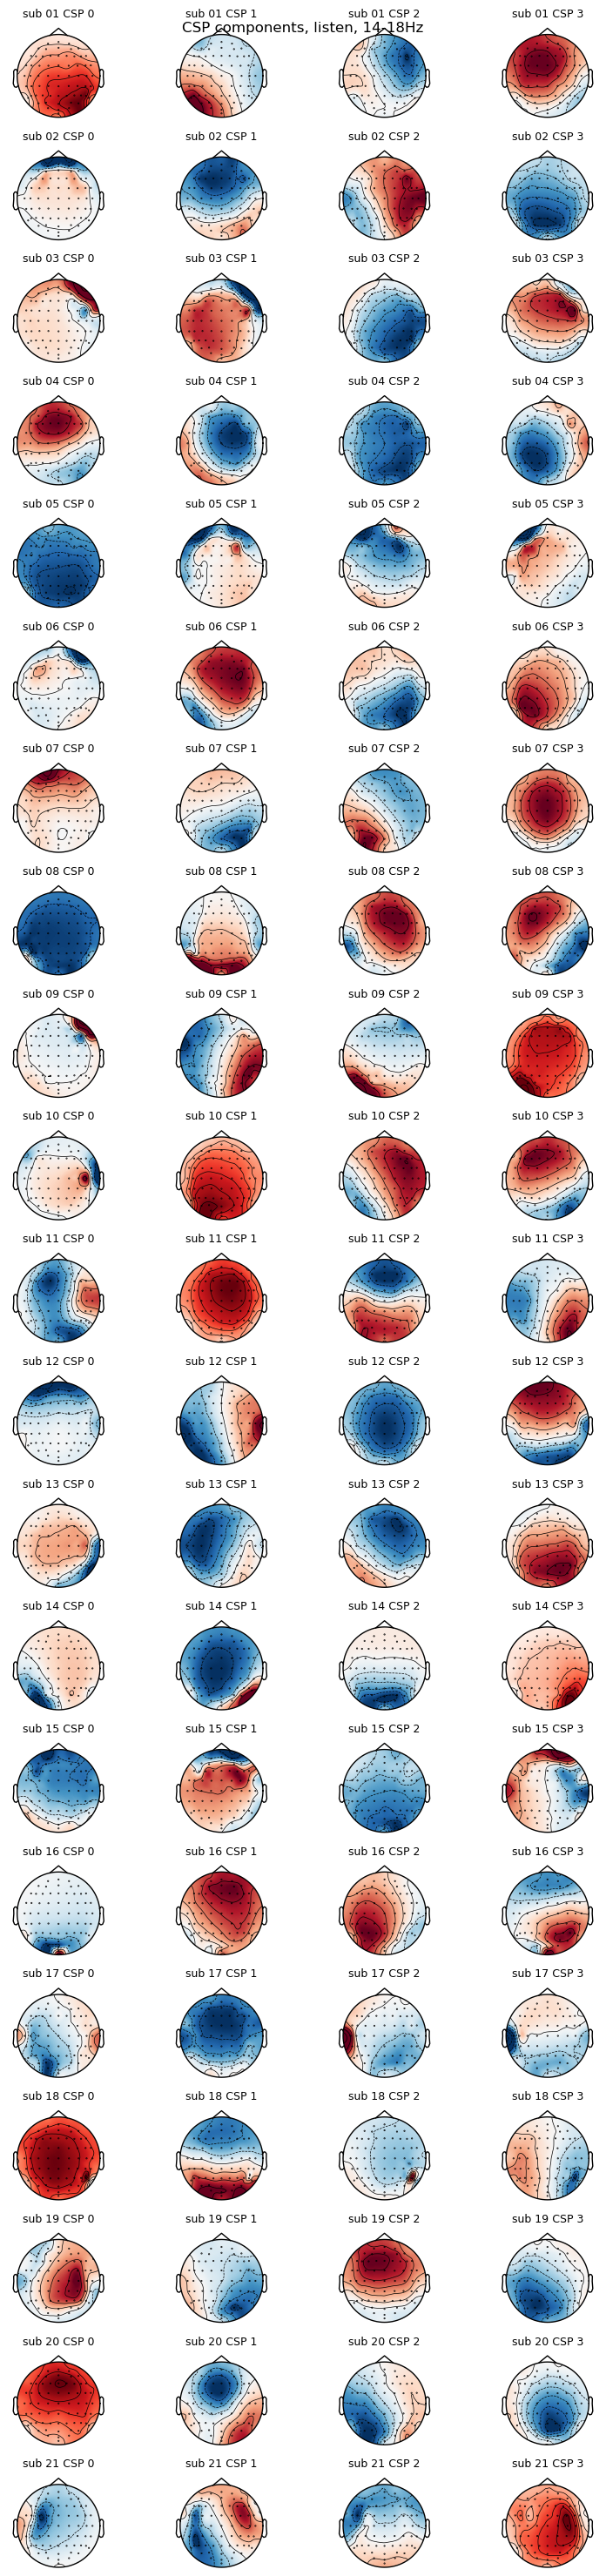

In [67]:

fig, axes = plt.subplots(n_subs, 4, figsize = (8,30))

for i, sub in enumerate(subjects_to_process): 
    
    csp = pickle.load(open(f'./CSP_components_{task}_14-18Hz/csp_sub_{sub}.pkl', 'rb'))
    patterns = csp.patterns_
    for j in range(patterns.shape[0]-1):
        ax = axes[i,j]
        mne.viz.plot_topomap(patterns[j], new_info, axes = ax, show = False)
        ax.set_title(f'sub {sub} CSP {j}', fontsize = 9)

fig.suptitle(f'CSP components, {task}, 14-18Hz')
plt.tight_layout()
plt.show()

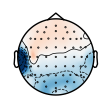

(<matplotlib.image.AxesImage at 0x15c4aa350>,
 <matplotlib.contour.QuadContourSet at 0x15c4aa490>)

In [39]:
patterns = csp.patterns_
plot_topomap(patterns[3], new_info)

In [35]:
patterns.shape

(5, 64)

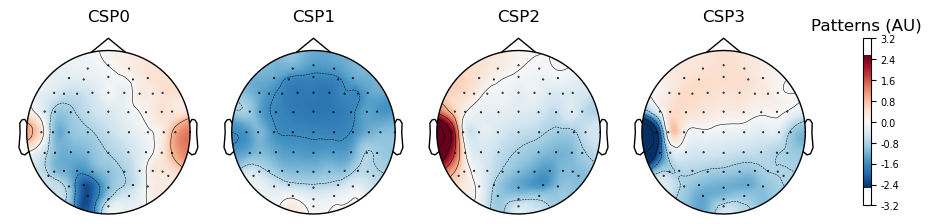

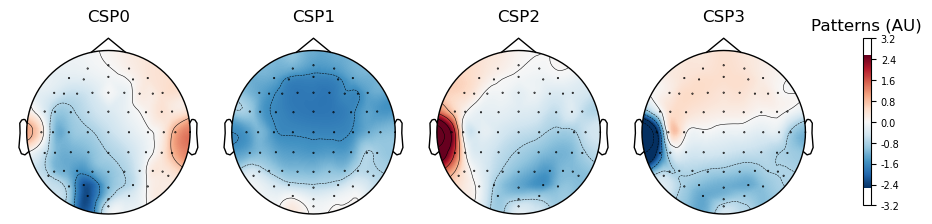

In [17]:
ch_names_64, _ = load_channels()
eeg_ch_names = ch_names_64
new_info = mne.pick_info(eps_post.info, sel=[eps_post.info['ch_names'].index(ch) for ch in eeg_ch_names])

csp_2.plot_patterns(new_info, ch_type="eeg", units="Patterns (AU)", size=1.5)